<a href="https://colab.research.google.com/github/SinaRampe/kb_download/blob/main/cpc_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cpic_recommendations_url = "https://api.cpicpgx.org/v1/recommendation"

def fetch_cpic_recommendations():

    response = requests.get(cpic_recommendations_url)
    data = response.json()

    return data

In [4]:
recommendations = fetch_cpic_recommendations()

In [5]:
df = pd.DataFrame(recommendations)

In [6]:
df.shape

(2098, 16)

In [7]:
df.head(2)

,id,guidelineid,drugid,implications,drugrecommendation,classification,phenotypes,activityscore,allelestatus,lookupkey,population,comments,version,dosinginformation,alternatedrugavailable,otherprescribingguidance
0,3296994,100421,RxNorm:190521,{'HLA-B': 'Low or reduced risk of abacavir hyp...,Use abacavir per standard dosing guidelines,Strong,{},{},{'HLA-B': 'HLA-B*57:01 negative'},{'HLA-B': '*57:01 negative'},general,n/a,1,False,False,False
1,3296995,100421,RxNorm:190521,{'HLA-B': 'Significantly increased risk of aba...,Abacavir is not recommended,Strong,{},{},{'HLA-B': 'HLA-B*57:01 positive'},{'HLA-B': '*57:01 positive'},general,n/a,1,False,False,False


In [8]:
unique_prefixes = set()

for drug_id in df['drugid']:

    prefix = drug_id.split(':')[0]
    unique_prefixes.add(prefix)

print("Unique prefixes in the 'drugid' column:", unique_prefixes)

Unique prefixes in the 'drugid' column: {'ATC', 'RxNorm'}


In [3]:
def get_drug_name(drug_id):  

  base_url = "https://rxnav.nlm.nih.gov/REST"

  try:

    if drug_id.startswith('RxNorm:'):

        rxnorm_id = drug_id.split(':')[1]
        url = f"{base_url}/rxcui/{rxnorm_id}.json"

    elif drug_id.startswith('ATC:'):

        atc_code = drug_id.split(':')[1]
        url = f"{base_url}/rxcui.json?idtype=ATC&id={atc_code}"

    response = requests.get(url)
    
    if response.status_code != 200:

        raise Exception(f"API request failed with status {response.status_code}")

    data = response.json()

    if drug_id.startswith('RxNorm:'):

        drug_name = data['idGroup']['name']

    elif drug_id.startswith('ATC:'):

        if 'results' not in data or len(data['results']) == 0:

            raise Exception(f"No drug name found for ATC code {atc_code}")

        drug_name = data['results'][0]['generic_name']

    return drug_name

  except Exception as e:

    print(f"Error for drug_id {drug_id}: {e}")

    return None

In [9]:
df['drug_name'] = np.nan

for index, row in df.iterrows():

    drug_id = row['drugid']
    drug_name = get_drug_name(drug_id)
    df.loc[index, 'drug_name'] = drug_name


Error for drug_id ATC:D06AX07: No drug name found for ATC code D06AX07
Error for drug_id ATC:D06AX07: No drug name found for ATC code D06AX07
Error for drug_id ATC:D06AX07: No drug name found for ATC code D06AX07
Error for drug_id RxNorm:NA: API request failed with status 404
Error for drug_id RxNorm:NA: API request failed with status 404
Error for drug_id RxNorm:NA: API request failed with status 404


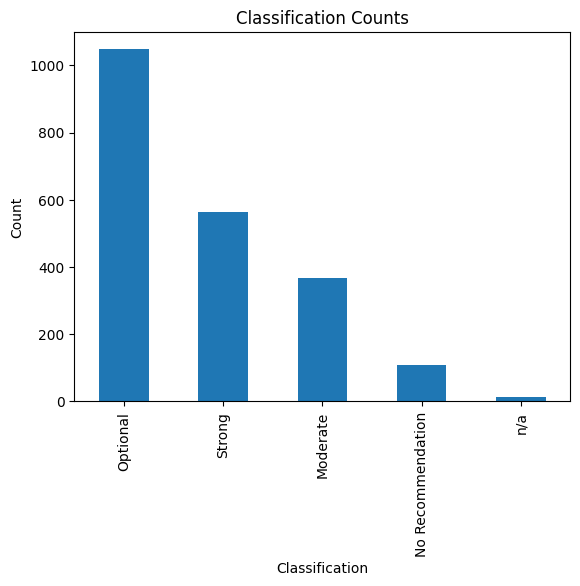

In [10]:
classification_counts = df['classification'].value_counts()

classification_counts.plot(kind='bar')

plt.title('Classification Counts')
plt.xlabel('Classification')
plt.ylabel('Count')

plt.show()

In [11]:
filtered_df = df[df['classification'] == 'Strong']

In [13]:
filtered_df.shape

(565, 17)

In [12]:
unique_drugids = filtered_df['drugid'].nunique()
unique_drugids

102

In [ ]:
df.to_csv('cpc_recommendations.csv')
filtered_df.to_csv('filtered_cpc_recommendations.csv')